In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import tensorflow as tf
system = os.name
if system == 'posix':
    KAGGLE = True
else:
    KAGGLE = False
print(os.name)

if KAGGLE:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)

nt
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
if KAGGLE:
    !pip install ../input/keras-applications/Keras_Applications-1.0.8/ -f ./ --no-index
    !pip install ../input/image-classifiers/image_classifiers-1.0.0/ -f ./ --no-index
    !pip install ../input/efficientnet-1-0-0/efficientnet-1.0.0/ -f ./ --no-index
    !pip install ../input/segmentationmodels/ -f ./ --no-index    

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN, Linknet
from segmentation_models.losses import bce_jaccard_loss
from tqdm.notebook import tqdm
from glob import glob
print('tensorflow version:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
pd.set_option('display.max_columns', None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
if not KAGGLE:
    res = pd.read_csv("../models/results.csv", index_col = 0)
else: res = 0
res

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds,mixed_precision,aughard,norm,bnw,weights,triple,reduce_dims
0,6,1,256,1,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,4,256,1,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.500000,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0010,NaN,NaN,NaN,kfold,NaN,24.666667,NaN,NaN,nan 0.2318 0.3154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1,256,4,64,1,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,NaN,0.000000,0.516637,0.077527,0.0775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,15.000000,0.027320,0.777308,0.7773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,25,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,19.000000,0.019676,0.884997,0.8850,False,NaN,NaN,NaN,NaN,NaN,NaN
6,17,4,256,4,16,30,20,efficientnetb5,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,13.000000,0.083721,0.637541,0.8200 0.8174 0.1290 0.7837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,16.000000,0.033654,0.662921,0.6629,True,NaN,NaN,NaN,NaN,NaN,NaN
8,31,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,11.000000,0.073768,0.667674,0.6677,True,NaN,NaN,NaN,NaN,NaN,NaN
9,26,1,256,4,32,100,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,46.000000,0.025203,0.899880,0.8999,False,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
TEST = False
PLT_RAW = True
if KAGGLE:
    TEST = True
    PLT_RAW = False

VERS = [47]
THRESHOLD = [0.5]
CONSENSUS = 0.8
DATA_PATH = f"../input/hubmap-kidney-segmentation"
if KAGGLE:
    MDLS_PATH = "../input/kidneymodel"
else:
    MDLS_PATH = "../models"

PAR_DICT = {}

for VER in VERS:
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
    PAR_DICT[VER] = {"MDL_PATH": MDL_PATH}
SUB_PATH = f"{DATA_PATH}/test" if TEST else f"{DATA_PATH}/train"
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
EXPAND = 4
MIN_OVERLAP = 256
STRATEGY = tf.distribute.get_strategy()
TTAS = [0, 1, 2, 3]
FOLDS = [0]

VOTERS = 1
TARGET_IMG = 'afa5e80ztu98.tiff'
start_time = time.time()
Y_SHFT = -40
X_SHFT = -24

In [7]:
for VER in VERS:
    with open(f"{PAR_DICT[VER]['MDL_PATH']}/params.json") as file:
        PARAMS = json.load(file)
        PAR_DICT[VER]["PARAMS"] = PARAMS
    print(f"loaded params: {PARAMS}")

loaded params: {'version': 47, 'folds': 1, 'img_size': 256, 'resize': 4, 'batch_size': 128, 'epochs': 100, 'patience': 20, 'backbone': 'efficientnetb0', 'loss': 'bce_dice', 'mirror': False, 'umodel': 'link', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0001, 'split': 'dont', 'seed': 69, 'mixed_precision': True, 'aughard': True, 'bavg_epoch': 97.0, 'bavg_loss': 0.012694964185357094, 'bavg_dice_coef': 0.9112770557403564, 'dice_by_folds': '0.9113'}


In [8]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

def global_shift_mask(maskpred1, y_shift, x_shift):
    """
    applies a global shift to a mask by padding
    one side and cropping from the other
    """
    if y_shift < 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(0,abs(y_shift)), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, :maskpred1.shape[1]]
    elif y_shift >= 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], abs(x_shift):]
    elif y_shift >= 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], :maskpred1.shape[1]]
    elif y_shift < 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(0, abs(y_shift)), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, abs(x_shift):]
    return maskpred3

In [9]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - params["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = 0.001):
    if backbone == "efficientnetb0":
        weights = f"{MDLS_PATH}/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"

    elif backbone == "efficientnetb1":
        weights = f"{MDLS_PATH}/efficientnet-b1_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "efficientnetb2":
        weights = f"{MDLS_PATH}/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "efficientnetb7":
        weights = f"{MDLS_PATH}/efficientnet-b7_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "inceptionv3":
        weights = f"{MDLS_PATH}/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
        
    elif backbone == "resnext50":
        weights = f"{MDLS_PATH}/resnext50_imagenet_1000_no_top.h5"
    
    elif backbone == "resnet50":
        weights = f"{MDLS_PATH}/resnet50_imagenet_1000_no_top.h5"
    
    elif backbone == "seresnet50":
        weights = f"{MDLS_PATH}/seresnet50_imagenet_1000_no_top.h5"
        
    elif backbone == "densenet201":
        weights = f"{MDLS_PATH}/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
        
    elif backbone == "resnext101":
        weights = f"{MDLS_PATH}/resnext101_imagenet_1000_no_top.h5"
        
        
        
   # else:
     #   raise AttributeError("backbone unknown")
    if not KAGGLE:
        weights = "imagenet"
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
            
        elif loss_type == "bce_jaccard_loss":
            loss = bce_jaccard_loss
            
        else:
            raise AttributeError("loss mode parameter error")
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = weights,
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = weights,
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
            
        elif umodel == "link":
            model = Linknet(backbone_name = backbone, encoder_weights = weights,
                            input_shape = input_shape,
                            classes = classes, activation = "sigmoid")
            
        else:
            raise AttributeError("umodel mode parameter error")
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr)
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

In [10]:
def make_grid(shape, window = 256, min_overlap = 32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num = nx, endpoint = False, dtype = np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num = ny, endpoint = False, dtype = np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype = np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)

def flip(img, axis = 0):
    if axis == 1:
        return img[::-1, :, ]
    elif axis == 2:
        return img[:, ::-1, ]
    elif axis == 3:
        return img[::-1, ::-1, ]
    else:
        return img

In [11]:
def norm_img(im):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = im * (255 / im.max())
    im[im > 255] = 255
    im = np.round(im).astype(np.uint8)
    return im

def triple_dims(im):
    im = np.transpose(np.array([im,im,im]), (1, 2, 0))
    return im

subsets = [[0],[1],[2],[0,1],[0,2],[1,2],[]]

In [12]:
img_files = [x for x in os.listdir(SUB_PATH) if ".tiff" in x]
print(f"images idxs: {img_files}")

images idxs: ['0486052bb.tiff', '095bf7a1f.tiff', '1e2425f28.tiff', '26dc41664.tiff', '2f6ecfcdf.tiff', '4ef6695ce.tiff', '54f2eec69.tiff', '8242609fa.tiff', 'aaa6a05cc.tiff', 'afa5e8098.tiff', 'b2dc8411c.tiff', 'b9a3865fc.tiff', 'c68fe75ea.tiff', 'cb2d976f4.tiff', 'e79de561c.tiff']


In [65]:
subm = {}
models = []
VER_FOLDS = []
THRESH_FOLDS = []
if PLT_RAW:
    complete_results = []
tile_size = int(PARAMS["img_size"] * EXPAND)
for i, VER in enumerate(VERS):
    PARAMS = PAR_DICT[VER]["PARAMS"]
    MDL_PATH = PAR_DICT[VER]["MDL_PATH"]
    for fold_path in glob(f"{MDL_PATH}/*.hdf5"):
        checkpoint_path = fold_path
        model = get_model(
            PARAMS["backbone"],
            input_shape = (tile_size, tile_size, 3),
            loss_type = PARAMS["loss"],
            umodel = PARAMS["umodel"]
        )
        model.load_weights(checkpoint_path)
        models.append(model)
        VER_FOLDS.append(VER)
        THRESH_FOLDS.append(THRESHOLD[i])
        print("model loaded:", checkpoint_path)

for i_img, img_file in enumerate(img_files):
    print("-" * 20, img_file, "-" * 20)
    img_data = rasterio.open(os.path.join(SUB_PATH, img_file), transform=IDNT)
    print("img shape: ", img_data.shape)
    if img_data.count != 3:
        print("img file with subdatasets as channels")
        layers = [rasterio.open(subd) for subd in img_data.subdatasets]
    img_preds = np.zeros(img_data.shape, dtype=np.uint8)
    if PLT_RAW:
        img_preds_mdls_raw = {}
        for VER in VERS:
            img_preds_mdls_raw[VER] = np.zeros(img_data.shape, dtype = np.float32)
    
    tile_resized = int(tile_size * PARAMS["resize"])
    slices = make_grid(
        img_data.shape,
        window = tile_resized,
        min_overlap = MIN_OVERLAP
    )
    
    for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
        if img_data.count == 3: #normal
            img = img_data.read(
                [1, 2, 3],
                window = Window.from_slices((x1, x2), (y1, y2))
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((tile_resized, tile_resized, 3), dtype = np.uint8)
            for fl in range(3):
                img[:, :, fl] = layers[fl].read(
                    window = Window.from_slices((x1, x2), (y1, y2))
                )
        img = cv2.resize(img, (tile_size, tile_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        pred = np.zeros((tile_size, tile_size), dtype = np.float32)
        if PLT_RAW:
            pred_raw = {}
            for VER in VERS:
                pred_raw[VER] = np.zeros((tile_size, tile_size), dtype = np.float32)
        i = 0
        for model1 in models:
            VER = VER_FOLDS[i]
            img_cust = img
            if "norm" in PAR_DICT[VER]["PARAMS"].keys():
                if PAR_DICT[VER]["PARAMS"]["norm"]:
                    img_cust = norm_img(img_cust)
                    img_cust = triple_dims(img_cust)        
            
            for tta_mode in TTAS:
                img_aug = flip(img_cust, axis = tta_mode)
                img_aug = np.expand_dims(img_aug, 0)
                img_aug = img_aug.astype(np.float32) / 255
                pred_aug = np.zeros((tile_size, tile_size), dtype = np.float32)
                if "reduce_dims" in PAR_DICT[VER]["PARAMS"].keys():
                    if PAR_DICT[VER]["PARAMS"]["reduce_dims"]:
                        im = np.transpose(img_aug[0], (2,0,1))
                        for inds in subsets:
                            im_red = im.copy()
                            for j in inds:
                                im_red[j] = 0
                            im_red = np.transpose(im_red, (1, 2, 0))
                            im_pred = np.expand_dims(im_red, 0)
                            prediction = model1.predict(im_pred)
                            pred_aug += np.squeeze(prediction > THRESH_FOLDS[i]) / len(models) / 7
                    else:
                        prediction = model1.predict(img_aug)
                        pred_aug += np.squeeze(prediction > THRESH_FOLDS[i]) / len(models)
                else:
                    prediction = model1.predict(img_aug)
                    pred_aug += np.squeeze(prediction > THRESH_FOLDS[i]) / len(models)
                pred += flip(pred_aug, axis = tta_mode) / len(TTAS)
                if PLT_RAW:
                    pred_aug_raw = np.zeros((tile_size, tile_size), dtype = np.float32)
                    pred_aug_raw += np.squeeze(prediction)
                    pred_raw[VER] += flip(pred_aug_raw, axis = tta_mode) / len(TTAS)
                
                
            i += 1
        pred = cv2.resize(pred, (tile_resized, tile_resized))
        img_preds[x1:x2, y1:y2] = img_preds[x1:x2, y1:y2] + \
            (pred > CONSENSUS).astype(np.uint8)
        if PLT_RAW:
            for VER in VERS:
                pred_raw[VER] = cv2.resize(pred_raw[VER], (tile_resized, tile_resized))
                img_preds_mdls_raw[VER][x1: x2, y1: y2] = pred_raw[VER]
    del img, pred, img_aug, pred_aug; gc.collect()
    print("img max", np.max(img_preds), "| voters:", VOTERS)
    if img_file == TARGET_IMG:
        print("global shift")
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
        img_preds = global_shift_mask(img_preds, Y_SHFT, X_SHFT)
    else:
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
    rle_pred = rle_encode_less_memory(img_preds)
    subm[i_img] = {"id": img_file.replace(".tiff", ""), "predicted": rle_pred}
    if PLT_RAW:
        #img_preds_mdls_raw[69420] = np.array([69,420])
        #df = pd.DataFrame.from_dict(img_preds_mdls_raw, orient = "index")
        complete_results.append(img_preds_mdls_raw)
        #df = df[df.index != 69420]
        #df.to_csv(f"../models/temp/{img_file.replace('.tiff','')}.csv")
        #del df, img_preds_mdls_raw; gc.collect()
        del img_preds_mdls_raw; gc.collect()
    del img_preds, img_data, rle_pred; gc.collect()

del model, models ; gc.collect()
elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

model loaded: ../models/models_v047\model_0.hdf5
-------------------- 0486052bb.tiff --------------------
img shape:  (25784, 34937)


0486052bb.tiff:   0%|          | 0/70 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 095bf7a1f.tiff --------------------
img shape:  (38160, 39000)
img file with subdatasets as channels


095bf7a1f.tiff:   0%|          | 0/110 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 1e2425f28.tiff --------------------
img shape:  (26780, 32220)
img file with subdatasets as channels


1e2425f28.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [66]:
df_sub = pd.DataFrame(subm).T
df_sub

,id,predicted
0,0486052bb,101727669 13 101753450 25 101779233 28 1018050...
1,095bf7a1f,114079216 5 114117375 7 114155529 13 114193688...


In [67]:
df_sub.to_csv("submission.csv", index = False)

In [68]:
def dice_np(pred, true, k = 1):
    intersection = np.sum(pred[true == k]) * 2
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice(mask, mask_lrg, th = 1):
    mask_pred = np.squeeze(mask_lrg >= th)
    return dice_np(mask, mask_pred)
    
def get_best_th_dice(mask, mask_lrg, n=20, plot = False):
    thresholds = np.linspace(0, 1, n)
    dices = [get_dice(mask, mask_lrg, th) for th in thresholds]
    n_max = np.argmax(dices)
    if plot:
        plt.plot(thresholds, dices)
        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
        plt.show()
    return thresholds, dices, n_max

********************
0486052bb
(25784, 34937, 3)
(25784, 34937, 3)
(25784, 34937)
(25784, 34937)
dice_coef: 0.9344658252631699


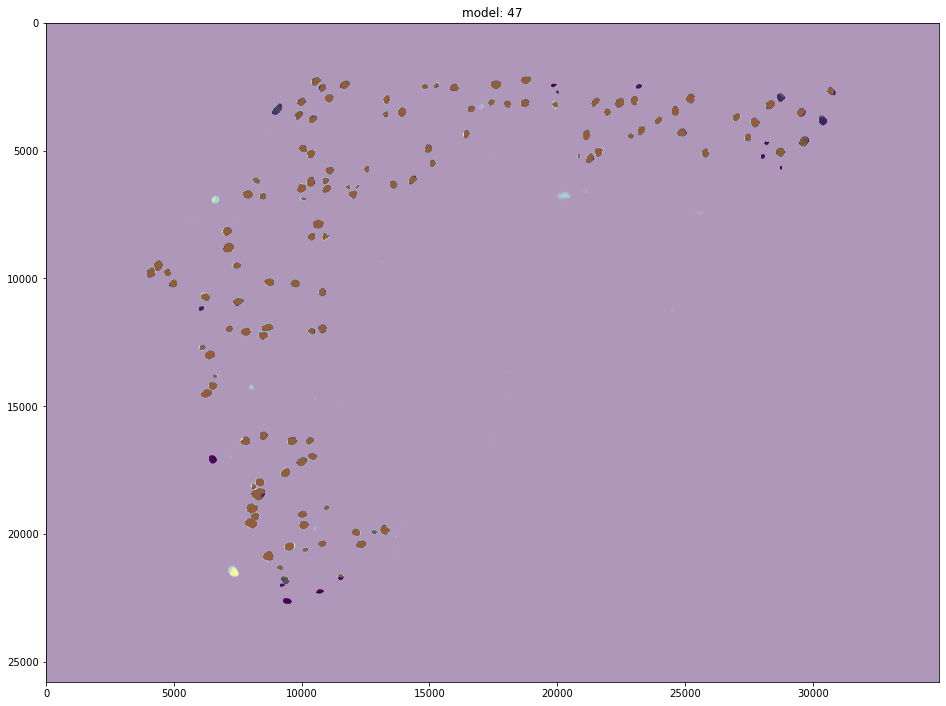

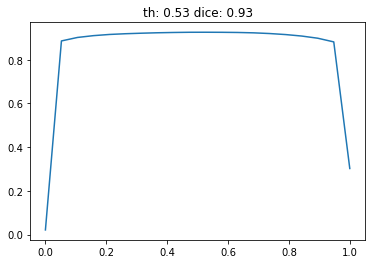

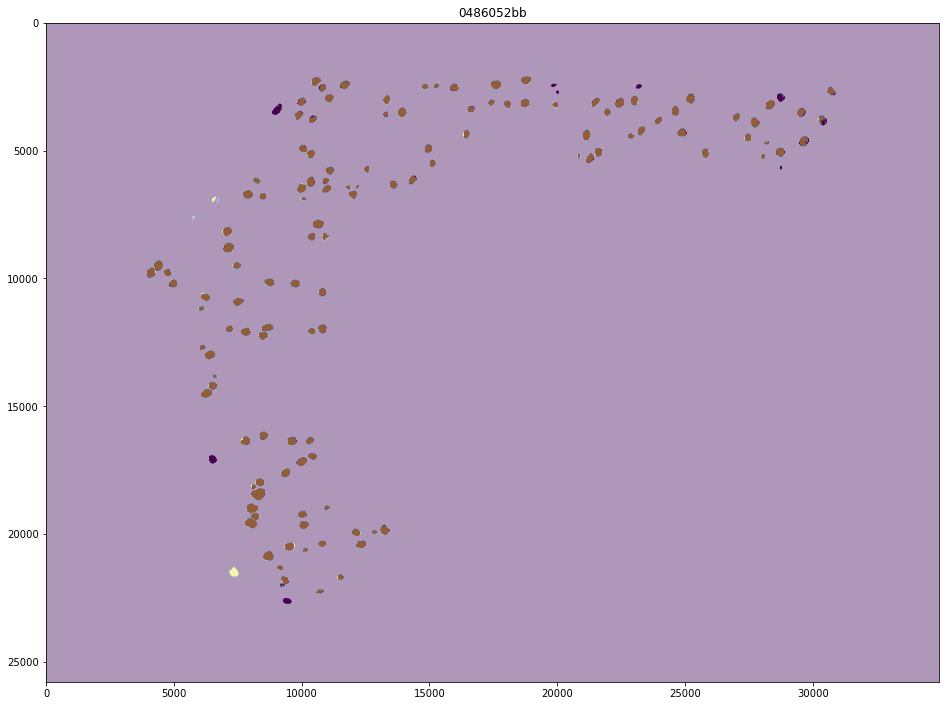

********************
095bf7a1f
(3, 38160, 39000)
(38160, 39000, 3)
(38160, 39000)
(38160, 39000)
dice_coef: 0.9428635426730351


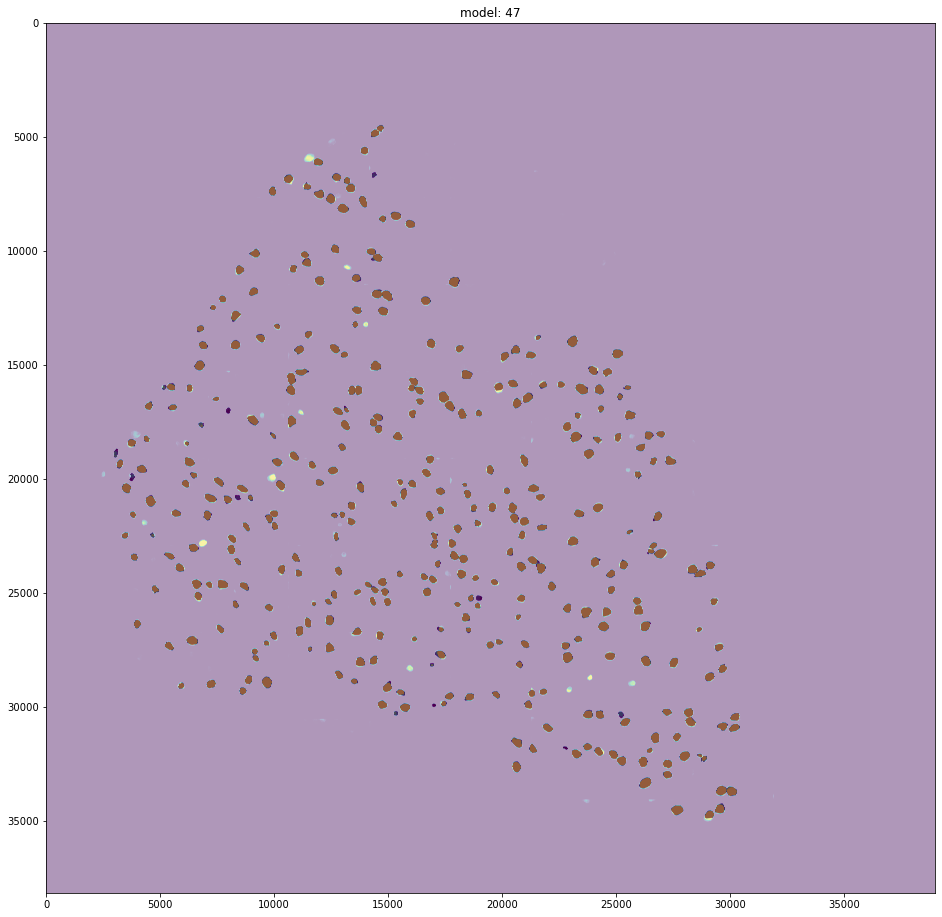

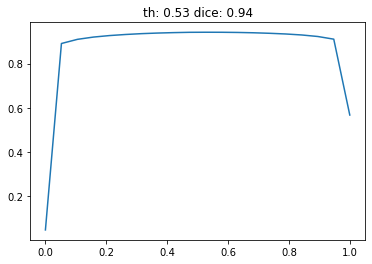

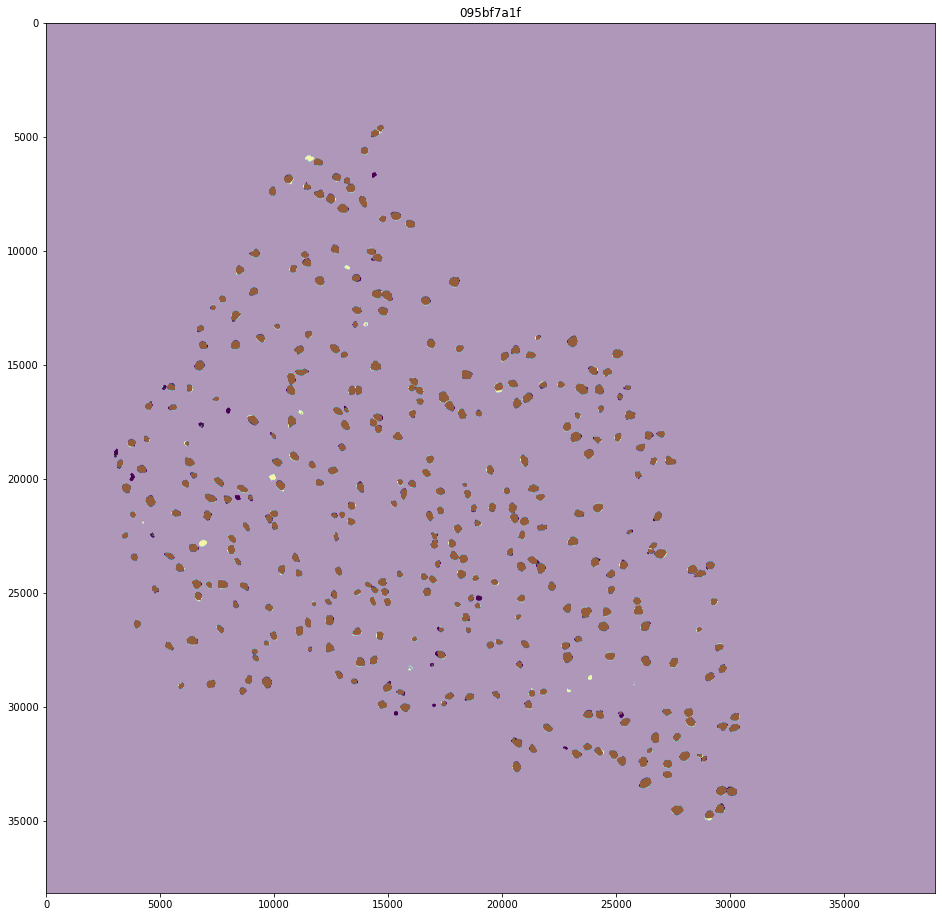

average dice_coef:0.9086871008449536
time elapsed: 65 min, 18 sec


In [69]:
if not KAGGLE:
    dices = []
    PLOT = True
    for i in df_sub.index:
        if not TEST:
            mdlsstr = ""
            for VER in VERS:
                    mdlsstr += f"{VER}-"
            threshstr = ""
            for THRESH in THRESHOLD:
                 threshstr += f"{int(THRESH*100)}-"
            df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
            idx = df_sub.iloc[i].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            print("*" * 20)
            print(idx)
            print(img.shape)
            if len(img.shape) == 5: img = img.squeeze()
            if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[i].predicted], (img.shape[1], img.shape[0]))
            msk = enc2mask([df_masks.loc[idx, "encoding"]], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            print(msk.shape)
            dice = get_dice(msk_p, msk)
            print(f"dice_coef: {dice}")
            dices.append([dice, msk_p.shape[0]* msk_p.shape[1]])
            
            if PLOT:
                #plt.figure(figsize = (16, 16))
                #plt.imshow(img)
                #plt.imshow(msk, alpha = 0.3)
                #plt.title(idx)
                #plt.show()

                #plt.figure(figsize = (16, 16))
                #plt.figure(figsize = (16, 16))
                #plt.imshow(img)
                #plt.imshow(msk_p, alpha = 0.3)
                #plt.title(idx)
                #plt.show()
                if PLT_RAW:
                    for VER in VERS:
                        mask_lrg = complete_results[i][VER]
                        plt.figure(figsize = (16,16))
                        plt.imshow(msk, cmap = "BuPu")
                        plt.imshow(mask_lrg, alpha = 0.4)
                        plt.title(f"model: {VER}")
                        plt.show()
                        
                        thresholds,dices1, n_max = get_best_th_dice(msk, mask_lrg, n=20, plot = False)
                        plt.plot(thresholds, dices1)
                        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices1[n_max]:.2f}")
                        plt.show()
                        del mask_lrg, dices1; gc.collect()
                    
                    
                
                plt.figure(figsize = (16, 16))
                plt.imshow(msk, alpha = 1, cmap = "BuPu")
                plt.imshow(msk_p, alpha = 0.4)
                plt.title(idx)
                if len(VERS) == 1:
                    save_path = PAR_DICT[VERS[0]]["MDL_PATH"]
                else:
                    save_path = MDLS_PATH
                plt.savefig(f'{save_path}/{idx}-mdls-{mdlsstr}-cons-{CONSENSUS}-thr-{threshstr}-tta-{len(TTAS)}-dice-{int(dice*100000)}.jpeg', transparent=True, bbox_inches = 'tight',
                                facecolor = 'k',pad_inches = 0)
                plt.show()
                plt.close()
                del msk, idx, img, msk_p; gc.collect()
        else:
            idx = df_sub.iloc[0].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[0].predicted], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            plt.figure(figsize = (16, 16))
            plt.imshow(img)
            plt.imshow(msk_p, alpha = 0.4)
            plt.title(idx)
            plt.show()
    if not TEST:
        coef = 0
        total = 0
        for dice in dices:
            coef += dice[0] * dice[1]
            total += dice[1]
        print(f"average dice_coef:{coef / total * 0.967}")

    elapsed_time = time.time() - start_time
    print(f"time elapsed: {elapsed_time // 60:.0f} min, {elapsed_time % 60:.0f} sec")

In [ ]:
plt.figure(figsize = (16, 16))
plt.imshow(msk, cmap = "Reds")
plt.imshow(mask_lrg, cmap = "Greens", alpha = 0.4)
plt.show()